begin to read data from /vepfs/wcf/G/zecheng/Long-Context-Data-Engineering/eval/needle/needle.jsonl | file size: 2.41 KB | file type: jsonl
n is 7
needle: The best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.
 expected_answer:  eat a sandwich and sit in Dolores Park on a sunny day.
model_name = llama-2-7b-80k_n7t2s0
   Document Depth  Context Length     Score  \
0            22.0           20538  0.000000   
1            22.0           20538  0.000000   
2            89.0           46590  0.166667   
3            89.0           46590  0.166667   
4            56.0            1000  0.000000   

                                                PPLs  needle_ppl  prefix_ppl  \
0  [4.701687335968018, 29.2757625579834, 12.20416...   29.275763    4.701687   
1  [4.701687335968018, 29.2757625579834, 12.20416...   29.275763    4.701687   
2  [1.2843257188796997, 19.169492721557617, 22.24...   19.169493    1.284326   
3  [1.2843257188796997, 19.1694927215

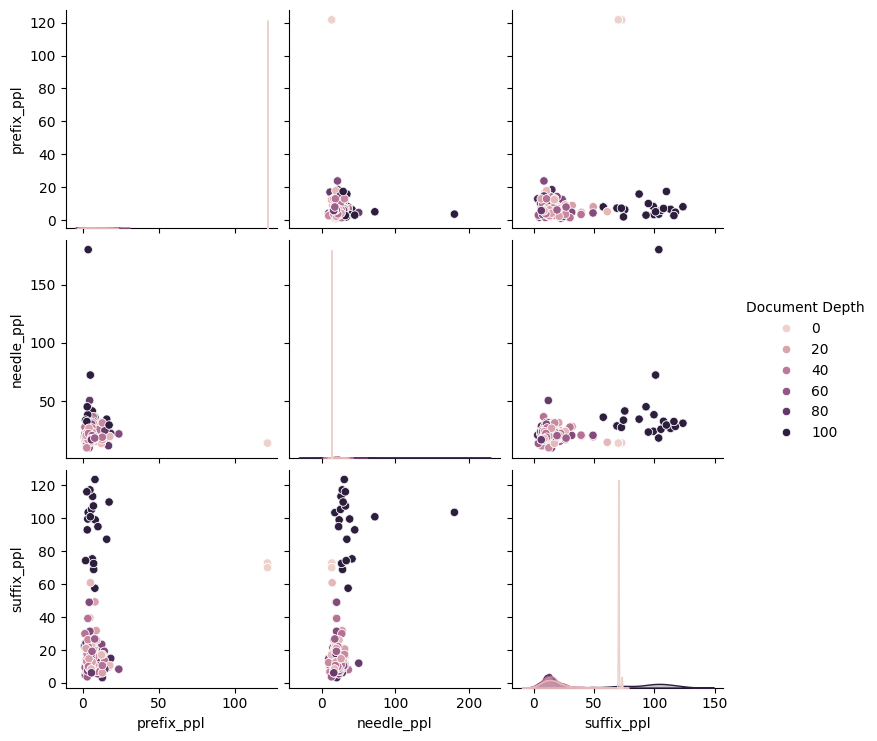

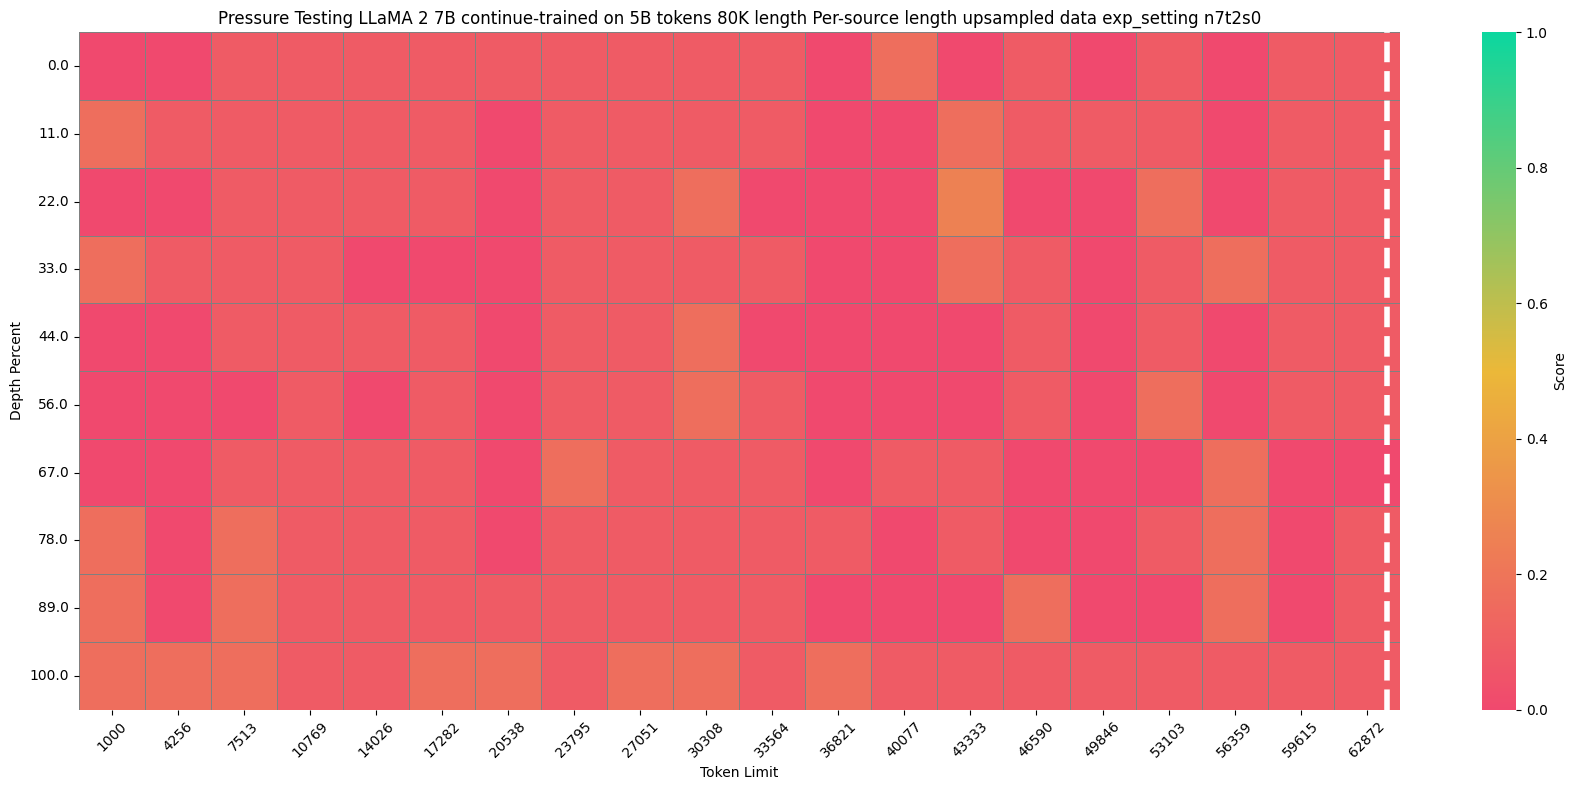

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import json
import glob
from modelzipper.tutils import *
import re


FOLDER_PATH = "/vepfs/wcf/G/zecheng/Long-Context-Data-Engineering/eval/needle/results/llama-2-7b-80k_n7t2s0/"
MODEL_NAME = "LLaMA 2 7B continue-trained on 5B tokens 80K length Per-source length upsampled data"
PRETRAINED_LEN=81920
NEEDLES = auto_read_data("/vepfs/wcf/G/zecheng/Long-Context-Data-Engineering/eval/needle/needle.jsonl")
EXP_NAME = FOLDER_PATH.split('/')[-2].split('_')[-1]

pattern = r"n(\d+)[a-zA-Z]"
match = re.search(pattern, FOLDER_PATH.split('/')[-2])
n = int(match.group(1))
print(f"n is {n}")
retrieval_question = NEEDLES[n-1]["retrieval_question"]
needle = NEEDLES[n-1]["value"]
expected_answer = needle[len(retrieval_question):]
print(f"needle: {needle}\n expected_answer: {expected_answer}")
expected_answer = expected_answer.lower().split()

# Path to the directory containing JSON results
folder_path = FOLDER_PATH
if("/" in folder_path):
    model_name = folder_path.split("/")[-2]
else: model_name = MODEL_NAME
print("model_name = %s" % model_name)

# Using glob to find all json files in the directory
json_files = glob.glob(f"{folder_path}*.json")

# List to hold the data
data = []
data2 = []

# Iterating through each file and extract the 3 columns we need
for file in json_files:
    with open(file, 'r') as f:
        json_data = json.load(f)
        # Extracting the required fields
        document_depth = json_data.get("depth_percent", None)
        context_length = json_data.get("context_length", None)
        # score = json_data.get("score", None)
        model_response = json_data.get("model_response", None).lower()
        needle = json_data.get("needle", None).lower()
        ppls = json_data.get("ppls", None)
        shift_st, shift_end = json_data.get("shift_st", None), json_data.get("shift_end", None)
        
        score = len(set(model_response.split()).intersection(set(expected_answer))) / len(expected_answer)
        # Appending to the list
        """
        量化PPLs的变化指标
        1. 前半句话的PPL prefix_ppl
        2. 后半句话的PPL suffix_ppl
        3. 中间needle的PPL needle_ppl
        """
        # bt_ppl_cg = abs(sum(ppls[shift_st-2: shift_st]) - sum(ppls[shift_st: shift_st+2])) / 2
        # end_ppl_cg = abs(sum(ppls[shift_end-2: shift_end]) - sum(ppls[shift_end: shift_end+2])) / 2
        # bt_ins_avg_ppl = sum(ppls[:shift_st]) / shift_st
        # ed_ins_avg_ppl = sum(ppls[shift_end: ]) / shift_end
        data.append({
            "Document Depth": document_depth, "Context Length": context_length,
            "Score": score, "PPLs": ppls, "needle_ppl": ppls[1], 
            "prefix_ppl": ppls[0], "suffix_ppl": ppls[2],
        })

        data.append({
            "Document Depth": document_depth, "Context Length": context_length,
            "Score": score, "PPLs": ppls, "needle_ppl": ppls[1], 
            "prefix_ppl": ppls[0], "suffix_ppl": ppls[2],
        })

        


# Creating a DataFrame
df = pd.DataFrame(data)
locations = list(df["Context Length"].unique())
locations.sort()
for li, l in enumerate(locations):
    if(l > PRETRAINED_LEN): break
pretrained_len = li
print(df.head())
print("Overall score %.3f" % df["Score"].mean())


# sns.jointplot(x="prefix_ppl", y="suffix_ppl", data=df)
sns.pairplot(data=df, vars=['prefix_ppl', 'needle_ppl', 'suffix_ppl'], hue='Document Depth')
plt.show()


pivot_table = pd.pivot_table(df, values='Score', index=['Document Depth', 'Context Length'], aggfunc='mean').reset_index() # This will aggregate
pivot_table = pivot_table.pivot(index="Document Depth", columns="Context Length", values="Score") # This will turn into a proper pivot
pivot_table.iloc[:5, :5]

# Create a custom colormap. Go to https://coolors.co/ and pick cool colors
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])

# Create the heatmap with better aesthetics
f = plt.figure(figsize=(17.5, 8))  # Can adjust these dimensions as needed
heatmap = sns.heatmap(
    pivot_table,
    vmin=0, vmax=1,
    cmap=cmap,
    cbar_kws={'label': 'Score'},
    linewidths=0.5,  # Adjust the thickness of the grid lines here
    linecolor='grey',  # Set the color of the grid lines
    linestyle='--'
)


# More aesthetics
model_name_ = MODEL_NAME
plt.title(f'Pressure Testing {model_name_} exp_setting {EXP_NAME}')  # Adds a title
plt.xlabel('Token Limit')  # X-axis label
plt.ylabel('Depth Percent')  # Y-axis label
plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
plt.yticks(rotation=0)  # Ensures the y-axis labels are horizontal
plt.tight_layout()  # Fits everything neatly into the figure area

# Add a vertical line at the desired column index
plt.axvline(x=pretrained_len + 0.8, color='white', linestyle='--', linewidth=4)

In [3]:
data

[]

model_name = llama-2-7b-80k_test_PPL_64000_ca2
Overall score 0.838


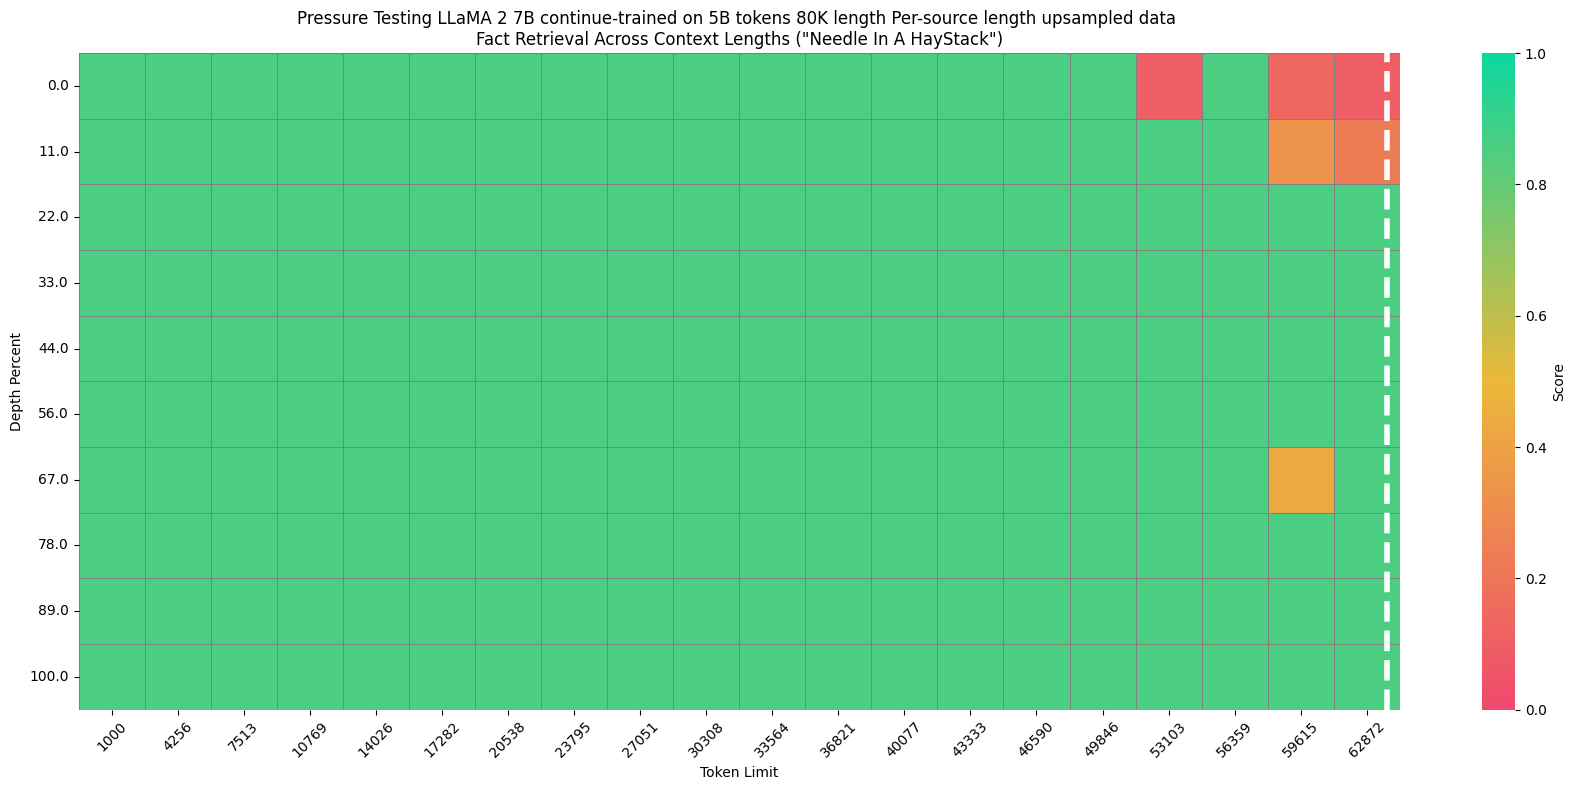

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import json
import glob

FOLDER_PATH = "/vepfs/wcf/G/zecheng/Long-Context-Data-Engineering/eval/needle/results/llama-2-7b-80k_test_PPL_64000_ca2/"
expected_answer_ca1 = "to walk around the city."
expected_answer_ca2 = "to walk around the city. It's a great way to see the sights and get some exercise at the same time."
MODEL_NAME = "LLaMA 2 7B continue-trained on 5B tokens 80K length Per-source length upsampled data"
PRETRAINED_LEN=81920

# Path to the directory containing JSON results
folder_path = FOLDER_PATH
if("/" in folder_path):
    model_name = folder_path.split("/")[-2]
else: model_name = MODEL_NAME
print("model_name = %s" % model_name)

# Using glob to find all json files in the directory
json_files = glob.glob(f"{folder_path}*.json")

# List to hold the data
data = []

# Iterating through each file and extract the 3 columns we need
for file in json_files:
    with open(file, 'r') as f:
        json_data = json.load(f)
        # Extracting the required fields
        document_depth = json_data.get("depth_percent", None)
        context_length = json_data.get("context_length", None)
        # score = json_data.get("score", None)
        model_response = json_data.get("model_response", None).lower()
        needle = json_data.get("needle", None).lower()
        ppls = json_data.get("ppls", None)
        shift_st, shift_end = json_data.get("shift_st", None), json_data.get("shift_end", None)
        expected_answer = expected_answer_ca2.lower().split()
        score = len(set(model_response.split()).intersection(set(expected_answer))) / len(expected_answer)
        # Appending to the list
        """
        量化PPLs的变化指标
        1. 前半句话的PPL prefix_ppl
        2. 后半句话的PPL suffix_ppl
        3. 中间needle的PPL needle_ppl
        """
        # bt_ppl_cg = abs(sum(ppls[shift_st-2: shift_st]) - sum(ppls[shift_st: shift_st+2])) / 2
        # end_ppl_cg = abs(sum(ppls[shift_end-2: shift_end]) - sum(ppls[shift_end: shift_end+2])) / 2
        # bt_ins_avg_ppl = sum(ppls[:shift_st]) / shift_st
        # ed_ins_avg_ppl = sum(ppls[shift_end: ]) / shift_end
        data.append({
            "Document Depth": document_depth, "Context Length": context_length,
            "Score": score, "PPLs": ppls, "needle_ppl": ppls[1], 
            "prefix_ppl": ppls[0], "suffix_ppl": ppls[2],
        })


# Creating a DataFrame
df = pd.DataFrame(data)
locations = list(df["Context Length"].unique())
locations.sort()
for li, l in enumerate(locations):
    if(l > PRETRAINED_LEN): break
pretrained_len = li

print("Overall score %.3f" % df["Score"].mean())

pivot_table = pd.pivot_table(df, values='Score', index=['Document Depth', 'Context Length'], aggfunc='mean').reset_index() # This will aggregate
pivot_table = pivot_table.pivot(index="Document Depth", columns="Context Length", values="Score") # This will turn into a proper pivot
pivot_table.iloc[:5, :5]

# Create a custom colormap. Go to https://coolors.co/ and pick cool colors
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#F0496E", "#EBB839", "#0CD79F"])

# Create the heatmap with better aesthetics
f = plt.figure(figsize=(17.5, 8))  # Can adjust these dimensions as needed
heatmap = sns.heatmap(
    pivot_table,
    vmin=0, vmax=1,
    cmap=cmap,
    cbar_kws={'label': 'Score'},
    linewidths=0.5,  # Adjust the thickness of the grid lines here
    linecolor='grey',  # Set the color of the grid lines
    linestyle='--'
)


# More aesthetics
model_name_ = MODEL_NAME
plt.title(f'Pressure Testing {model_name_} \nFact Retrieval Across Context Lengths ("Needle In A HayStack")')  # Adds a title
plt.xlabel('Token Limit')  # X-axis label
plt.ylabel('Depth Percent')  # Y-axis label
plt.xticks(rotation=45)  # Rotates the x-axis labels to prevent overlap
plt.yticks(rotation=0)  # Ensures the y-axis labels are horizontal
plt.tight_layout()  # Fits everything neatly into the figure area

# Add a vertical line at the desired column index
plt.axvline(x=pretrained_len + 0.8, color='white', linestyle='--', linewidth=4)


In [7]:
data

[]